In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
# PATH should point to repository folder
PATH = "/content/drive/My Drive/cpath_robustness"
sys.path.append(PATH)

In [3]:
# Load model
import torch
import torch.utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from torchvision import models
import os

def load_resnet(model_path, n_classes=2, pretrained=True, device="cuda:0"):
  model = models.resnet18(pretrained=pretrained)

  model.fc = nn.Sequential(
                        nn.Linear(512, n_classes),
                        nn.LogSoftmax(dim=1))
  
  model.load_state_dict(torch.load(model_path))
  
  model.to(device)
  model.eval()
  return model

model_names = ["std_pre_std_train.pt", "std_pre_std_train_adv_free_retrain_ce_lr_0_02_margin_0_1"]
model_path = os.path.join(PATH, "Models/" + model_names[0])
model = load_resnet(model_path)

In [4]:
# Create train and test dataset and dataloaders
import os
import numpy as np
from skimage.transform import resize
from PIL import Image

def get_dataloader(dataset, n=100, batch_size=8, num_workers=2, shuffle=False):
  if n is None or n > len(dataset):
    n = len(dataset)
  X_y = dataset[:n]
  X = X_y[0]
  y = X_y[1]
  predict_data = torch.utils.data.TensorDataset(X, y)
  return torch.utils.data.DataLoader(predict_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

DATAPATH = os.path.join(PATH, "Data/breast_folds.npz")

F = np.load(DATAPATH, allow_pickle=True)['F']
len(F)

Xtr=[]
ytr=[]
Xts=[]
yts=[]
ts_counts=[]

#Train data
for fol in [F[1],F[2]]:
  images, counts =fol
  for i in range(len(counts)):
    cc=counts[i]
    if cc[0]>=5:    
      ytr.append(1)
      
    elif cc[0]==0:
      ytr.append(0)
      

    else:
      continue
    im=Image.fromarray(np.uint8(images[i]))
    Xtr.append(np.transpose(np.array(im.resize( (224, 224))),(2,0,1)))
  

# Test data

images, counts =F[0]
for i in range(len(counts)):
  cc=counts[i]
  if cc[0]>=5:    
    yts.append(1)
    
  elif cc[0]==0:
    yts.append(0)
    

  else:
    continue
  ts_counts.append(cc[0])
  im=Image.fromarray(np.uint8(images[i]))
  Xts.append(np.transpose(np.array(im.resize( (224, 224))),(2,0,1)))#resize(images[i], (224,224,3)))

Xtr=np.array(Xtr)
Xts=np.array(Xts)
ytr=np.array(ytr)
yts=np.array(yts)
ts_counts=np.array(ts_counts)

Xtr=torch.FloatTensor(Xtr)
ytr= torch.LongTensor(ytr)
Xts=torch.FloatTensor(Xts)
yts= torch.LongTensor(yts)

test_dataset = torch.utils.data.TensorDataset(Xts, yts)

batch_size = 2
small_loader = get_dataloader(test_dataset, n=100, batch_size=batch_size)
big_loader = get_dataloader(test_dataset, n=1000, batch_size=batch_size)
full_loader =  get_dataloader(test_dataset, n=None, batch_size=batch_size)

In [5]:
# Import toolbox
from transforms import *
from optimisers import Optimiser, PGD, RandomSample
from evaluator import Evaluator

In [6]:
# Create some useful functions for plotting results
import matplotlib.pyplot as plt

def plot_change(param_values, all_scores, xlabel="", ylabel="", title="", x_range=None, y_range=None, y_ticks=None):
  fig = plt.figure()
  plot = sns.lineplot(x=param_values, y=all_scores)
  plot.set_xlabel(xlabel)
  plot.set_ylabel(ylabel)
  plot.set_title(title) 
  if x_range is not None:
    plot.set(xlim=x_range)
  if y_range is not None:
    plot.set(ylim=y_range)
  if y_ticks is not None:
    plot.set(yticks=y_ticks)     
  return fig

def display_results(input, adv_input, classes):
  in_out = model(input.unsqueeze(0))
  adv_out = model(adv_input.unsqueeze(0))

  in_index = torch.argmax(in_out).item()
  adv_index = torch.argmax(adv_out).item()

  in_class = classes[in_index]
  adv_class = classes[adv_index]

  in_conf = round(torch.exp(in_out)[0][in_index].item() * 100, 1)
  adv_conf = round(torch.exp(adv_out)[0][adv_index].item() * 100, 1)

  perturbation = adv_input - input

  fig = plt.figure(figsize=[13, 9])

  input = input.permute(1,2,0).detach().cpu().numpy()
  adv_input = adv_input.permute(1,2,0).detach().cpu().numpy()
  perturbation = perturbation.permute(1,2,0).detach().cpu().numpy()

  plt.subplot(1, 3, 1)
  plt.imshow(input.astype(int))
  plt.title(in_class + ", " + str(in_conf) + "% confidence")
  plt.xticks(ticks=[])
  plt.yticks(ticks=[])

  plt.subplot(1, 3, 2)
  rmse = np.sqrt(np.mean(np.power(perturbation, 2)))
  l_inf = np.max(np.abs(perturbation))

  min_val = np.min(np.abs(perturbation))
  max_val = np.max(np.abs(perturbation))
  if min_val < 1 and min_val != max_val:
    perturbation -= np.min(perturbation)
    scale_factor = 255/np.max(perturbation)
    perturbation *= scale_factor
  else:
    scale_factor = 1.0
    perturbation = np.abs(perturbation)
  plt.imshow(perturbation.astype(int))
  plt.title(f'Perturbation - scale factor: {scale_factor:.3f}')
  plt.xticks(ticks=[])
  plt.yticks(ticks=[])
  x_lab = f"L2: {rmse:.3f}, L infinity: {l_inf:.3f}"
  plt.xlabel(x_lab)    

  plt.subplot(1, 3, 3)
  plt.imshow(adv_input.astype(int))
  plt.title(adv_class + ", " + str(adv_conf) + "% confidence")
  plt.xticks(ticks=[])
  plt.yticks(ticks=[])

  return fig

In [7]:
# Define some metrics - these take the results of Evaluator.predict() and 
# compute a single score
from sklearn.metrics import accuracy_score
import seaborn as sns

def accuracy(results):
  labels = results["labels"]
  outputs = results["outputs"]
  _, predictions = torch.max(outputs, 1)
  return accuracy_score(labels, predictions)

def adversarial_accuracy(results):
  labels = results["labels"]
  outputs = results["adversarial_outputs"]
  _, predictions = torch.max(outputs, 1)
  return accuracy_score(labels, predictions)

def rmse(a):
  return torch.sqrt(torch.mean(torch.pow(a, 2)))

def input_sensitivity(results):
  outputs = torch.exp(results["outputs"])
  adv_outputs = torch.exp(results["adversarial_outputs"])
  mean_out_diff = torch.mean(torch.abs(outputs - adv_outputs))
  # print(mean_out_diff.item())
  return mean_out_diff.item()

def normalised_input_sensitivity(results):
  in_sens = input_sensitivity(results)

  pert_measures = results["perturbation_measures"]
  avg_pert = torch.mean(pert_measures)

  norm_in_sens = in_sens / avg_pert
  # print(norm_in_sens.item())  
  return norm_in_sens.item()

In [8]:
# Change these to suit your application
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ["Negative", "Positive"]

In [9]:
# Create an Evaluator object using the PixelTransform and the PGD optimiser
# Define the attack parameters
pixel_attack_params = {
    "epsilon": 0.1,
    "steps": 10,
    "constraint": "l2",
    "C": 2,
    "input_range": (0, 255)
}
# Define the transform parameters
pixel_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-0.2, 0.2)
}
# Create the evaluator - it requires a model, a dataset, a dataloader, an
# optimiser class, a transform class, parameters for the attack and the
# transform, and the desired device (cpu, cuda:0, etc.)
pixel_evaluator = Evaluator(model, test_dataset, small_loader, PGD, PixelTransform, pixel_attack_params, pixel_trans_params, device=device)

In [10]:
# Compute the results using the evaluator
results = pixel_evaluator.predict(adversarial=True, perturbation_measure=rmse, weight_measure=rmse)
# Compute some metrics using the results
acc = accuracy(results)
robust_acc = adversarial_accuracy(results)
in_sens = input_sensitivity(results)
norm_in_sens = normalised_input_sensitivity(results)
print(f"Accuracy: {acc}, robust accuracy: {robust_acc}, input sensitivity: {in_sens:.3f}, normalised input sensitivity: {norm_in_sens:.3f}")

Accuracy: 0.93, robust accuracy: 0.0, input sensitivity: 0.878, normalised input sensitivity: 0.441


Starting hyperparameters: {'epsilon': 0.1, 'steps': 10, 'constraint': 'l2', 'C': 0.0, 'input_range': (0, 255)}
0% complete...
23% complete...
46% complete...
69% complete...
92% complete...
Done.


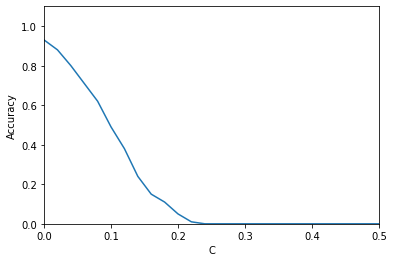

In [11]:
# Choose an attack parameter
param = "C"
# Choose a range of values
param_range = (0, 0.5)
# Choose the step size - the metric will be computed at each value of the 
# parameter
step_size = 0.02
# Choose a metric
metric = adversarial_accuracy
# Use the evaluator to compute the metric over the range of parameter values
# Set the kwargs to compute the correct set of results for the metric - in this
# case we need to adversarially perturb the images, so we set adversarial to
# True
param_values, all_scores = pixel_evaluator.metric_vs_strength(param, param_range, step_size, metric, adversarial=True)
# Use the helper function to plot the scores against the parameter values
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Accuracy", x_range=param_range, y_range=(0, 1.1))

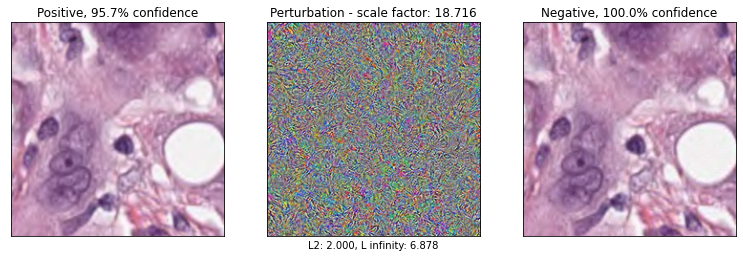

In [12]:
# Get the perturbed inputs directly from the evaluator by passing a list of
# dataset indices
inputs, adv_inputs = pixel_evaluator.attack_inputs([0])
# Use the helper function to display the original inputs, the difference between
# the original and perturbed inputs, and the perturbed inputs
for i, input_ in enumerate(inputs):
    display_results(input_, adv_inputs[i], classes)

Starting hyperparameters: {'epsilon': 0.02, 'steps': 0, 'constraint': 'l2', 'C': 2, 'input_range': (0, 255)}
0% complete...
27% complete...
55% complete...
82% complete...
Done.


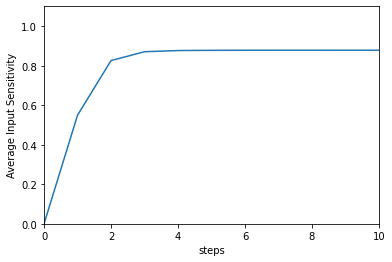

In [13]:
# Set some different hyperparameters for this experiment using a method of
# the evaluator object
new_pixel_attack_params = {
    "epsilon": 0.02,
    "steps": 10,
    "constraint": "l2",
    "C": 2,
    "input_range": (0, 255)
}
pixel_evaluator.set_attack_hyperparameters(new_pixel_attack_params)
# Choose a different attack parameter
param = "steps"
# Choose a range of values
param_range = (0, 10)
# Choose the step size - the metric will be computed at each value of the 
# parameter
step_size = 1
# Choose a different metric
metric = input_sensitivity
# Use the evaluator to compute the metric over the range of parameter values
# Set the kwargs to compute the correct set of results for the metric - we need 
# to compute a measure of the size of the perturbations, so we pass a function 
# handle that computes the rmse of the perturbation
param_values, all_scores = pixel_evaluator.metric_vs_strength(param, param_range, step_size, metric, adversarial=True, perturbation_measure=rmse)
# Use the helper function to plot the scores against the parameter values bjbv 
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Average Input Sensitivity", x_range=param_range, y_range=(0, 1.1))

In [14]:
# Repeat for another transform
stain_attack_params = {
    "epsilon": 0.002,
    "steps": 10,
    "constraint": "l2",
    "C": 0.2,
    "input_range": (0, 255)
}

stain_trans_params = {
    "input_range": (0, 255)
}

stain_evaluator = Evaluator(model, test_dataset, small_loader, PGD, StainTransform, stain_attack_params, stain_trans_params, device=device)

In [15]:
results = stain_evaluator.predict(adversarial=True, perturbation_measure=rmse, weight_measure=rmse)
acc = accuracy(results)
robust_acc = adversarial_accuracy(results)
in_sens = input_sensitivity(results)
norm_in_sens = normalised_input_sensitivity(results)
print(f"Accuracy: {acc}, robust accuracy: {robust_acc}, input sensitivity: {in_sens:.3f}, normalised input sensitivity: {norm_in_sens:.3f}")

Accuracy: 0.93, robust accuracy: 0.42, input sensitivity: 0.461, normalised input sensitivity: 0.045


Starting hyperparameters: {'epsilon': 0.002, 'steps': 10, 'constraint': 'l2', 'C': 0.0, 'input_range': (0, 255)}
0% complete...
23% complete...
46% complete...
69% complete...
92% complete...
Done.


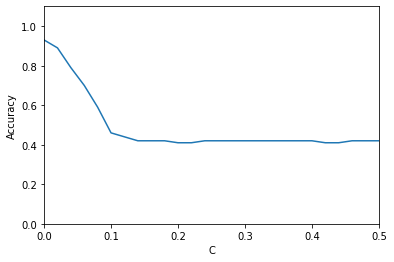

In [16]:
param = "C"
param_range = (0, 0.5)
step_size = 0.02
param_values, all_scores = stain_evaluator.metric_vs_strength(param, param_range, step_size, adversarial_accuracy, adversarial=True)
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Accuracy", x_range=param_range, y_range=(0, 1.1))

Starting hyperparameters: {'epsilon': 0.0, 'steps': 10, 'constraint': 'l2', 'C': 0.2, 'input_range': (0, 255)}
0% complete...
24% complete...
48% complete...
71% complete...
95% complete...
Done.


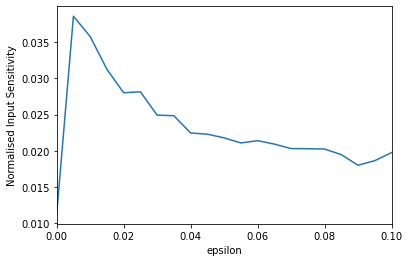

In [17]:
param = "epsilon"
param_range = (0, 0.1)
step_size = 0.005

param_values, all_scores = stain_evaluator.metric_vs_strength(param, param_range, step_size, normalised_input_sensitivity, adversarial=True, perturbation_measure=rmse)
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Normalised Input Sensitivity", x_range=param_range)

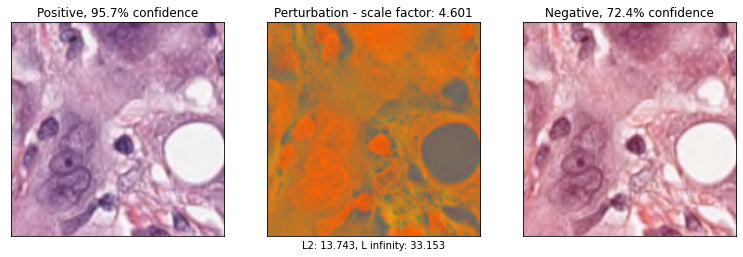

In [18]:
inputs, adv_inputs = stain_evaluator.attack_inputs([0])
for i, input_ in enumerate(inputs):
    display_results(input_, adv_inputs[i], classes)

In [19]:
# Create a new transform
from torch.autograd import Variable

class MeanTransform(Transform):
    # The class inherits from the abstract class Transform
    def __init__(self, input_shape, device, input_range=(0, 255), noise_range=(-0.1, 0.1)):
        # This method must take input_shape and device and input, and can 
        # optionally take any other desired arguments
        super().__init__(input_shape, device)
        self.input_range = input_range
        batch_size = input_shape[0]
        shape = (batch_size, 1)
        # self.base_weights defines the base perturbation from which to measure
        # the magnitude of the perturbation. Often it will be a tensor of zeros
        self.base_weights = torch.zeros(shape).to(device)
        # self.weights is a tensor with a grad function that will be optimised
        # using the provided optimiser to cause misclassification
        weights = torch.FloatTensor(*shape).uniform_(*noise_range).to(device)
        self.weights = Variable(weights, requires_grad=True).to(device)

    def forward(self, x):
        # This must perform a differentiable (with respect to self.weights) 
        # transform on the inputs x. The transform is parameterised by 
        # self.weights
        for i in range(self.input_shape[0]):
            x[i] = torch.clamp(x[i] + self.weights[i], *self.input_range)
        return x

In [20]:
# Create an evaluator using our new transform
mean_attack_params = {
    "epsilon": 0.5,
    "steps": 20,
    "constraint": "l2",
    "C": 30,
    "input_range": (0, 255)
}

mean_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-0.2, 0.2)
}

mean_evaluator = Evaluator(model, test_dataset, small_loader, PGD, MeanTransform, mean_attack_params, mean_trans_params, device=device)

In [21]:
results = mean_evaluator.predict(adversarial=True, perturbation_measure=rmse, weight_measure=rmse)
acc = accuracy(results)
robust_acc = adversarial_accuracy(results)
in_sens = input_sensitivity(results)
norm_in_sens = normalised_input_sensitivity(results)
print(f"Accuracy: {acc}, robust accuracy: {robust_acc}, input sensitivity: {in_sens:.3f}, normalised input sensitivity: {norm_in_sens:.3f}")

Accuracy: 0.93, robust accuracy: 0.87, input sensitivity: 0.064, normalised input sensitivity: 0.003


Starting hyperparameters: {'epsilon': 0.0, 'steps': 20, 'constraint': 'l2', 'C': 30, 'input_range': (0, 255)}
0% complete...
24% complete...
48% complete...
71% complete...
95% complete...
Done.


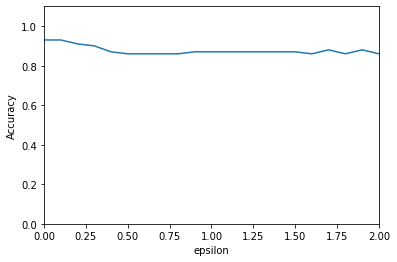

In [22]:
param = "epsilon"
param_range = (0, 2)
step_size = 0.1
param_values, all_scores = mean_evaluator.metric_vs_strength(param, param_range, step_size, adversarial_accuracy, adversarial=True)
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Accuracy", x_range=param_range, y_range=(0, 1.1))

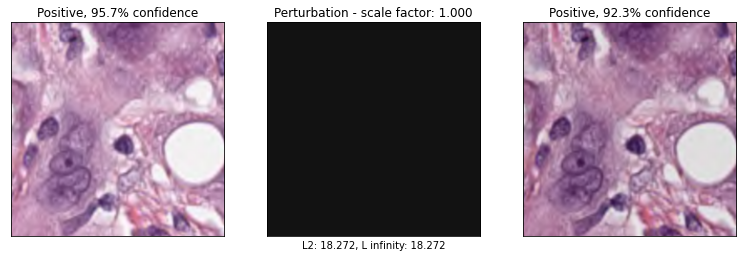

In [23]:
inputs, adv_inputs = mean_evaluator.attack_inputs([0])
for i, input_ in enumerate(inputs):
    display_results(input_, adv_inputs[i], classes)

In [24]:
# Create a training loop that uses adversarial transforms
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import dill
import random


def run_val(model, loader, criterion, device="cuda:0"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    num_examples = 0

    with torch.set_grad_enabled(False):
        for batch_no, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
            num_examples += len(preds)
            running_corrects += torch.sum(preds == labels.data)
            running_loss += loss.item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_corrects.double() / num_examples
    return epoch_loss, epoch_acc   

def print_update(phase, epoch_loss, epoch_acc):
  print(f'{phase}: Loss: {round(epoch_loss, 3)} Acc: {round(epoch_acc.item(), 3)}')

def training_bout(model, train_loader, val_loader, optimizer, criterion, adversarial=False, attacks=[], epochs=10, m=10, last_n=10, k=2, device="cuda:0"):
    since = time.time()

    acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch = 1
    num_examples = 0
    running_loss = 0.0
    running_corrects = 0
    running_adv_corrects = 0

    print(f'Epoch {epoch}/{epochs}')
    print('-' * 10)
    t_full = time.time()
    t1 = time.time()

    for i in range(int(epochs / m)):        
        model.train()

        batch_count = 0
        batches_per_epoch = len(train_loader)

        for batch_no, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)    

            if attacks:
                num_attacks = len(attacks)
                if num_attacks > k:
                    sub_attacks = random.sample(attacks, k)  
                else:
                    sub_attacks = attacks  

            with torch.set_grad_enabled(True):
                for repetition in range(m):
                    batch_count += 1

                    optimizer.zero_grad()

                    if adversarial and attacks:
                        adv_inputs = inputs.clone()
                        for attack in sub_attacks:
                            attack.model = model
                            if repetition == 0:
                                _, adv_inputs = attack.run_attack(adv_inputs, targets=labels, reset_weights=True)
                            else:
                                _, adv_inputs = attack.run_attack(adv_inputs, targets=labels, reset_weights=False) 
                         
                        outputs = model(adv_inputs)
                    else:
                        outputs = model(inputs)                                            
                   
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)
                                       
                    loss.backward(retain_graph=True)
                    optimizer.step()

                    num_examples += len(preds)
                    running_corrects += torch.sum(preds == labels.data)
                    running_loss += loss.item()

                    if batch_count % batches_per_epoch == 0:
                        epoch_loss = running_loss / batches_per_epoch
                        epoch_acc = running_corrects.double() / num_examples
                        print_update("Train", epoch_loss, epoch_acc)

                        epoch_loss_v, epoch_acc_v = run_val(model, val_loader, criterion, device=device)
                        print_update("Val", epoch_loss_v, epoch_acc_v)

                        print(f"{round(time.time() - t1, 2)}s")

                        epoch += 1
                        if epoch <= epochs:
                            print(f'Epoch {epoch}/{epochs}')
                            print('-' * 10)
                            t1 = time.time()

                        num_examples = 0
                        running_loss = 0.0
                        running_corrects = 0
                        running_adv_corrects = 0
                        
                        # deep copy the model
                        if epoch_acc_v >= best_acc and (last_n is None or epochs - epoch <= last_n):
                            best_acc = epoch_acc_v
                            best_model_wts = copy.deepcopy(model.state_dict())

                        acc_history.append(np.array([epoch_acc, epoch_acc_v]))

    print(f"Took: {round(time.time() - t_full, 2)}s")
    print(f'Best val Acc: {best_acc}')
    model.load_state_dict(best_model_wts)
    return model, np.array(acc_history)


def train_adv_free(model, dataloaders, criterion, optimizer, initial_epochs=0, adv_epochs=30, m=10, last_n=10, attacks=[], k=2, device="cuda:0"):
    train_loader = dataloaders["train"]
    val_loader = dataloaders["val"]
    # Initial standard training
    print("Initial Epochs... ")
    model, initial_hist = training_bout(model, train_loader, val_loader, optimizer, criterion, m=1, epochs=initial_epochs, adversarial=False, attacks=[], last_n=last_n, k=k, device=device)
    # Free adversarial training
    print("Adversarial Epochs...")
    model, adv_hist = training_bout(model, train_loader, val_loader, optimizer, criterion, m=m, epochs=adv_epochs, adversarial=True, attacks=attacks, last_n=last_n, k=k, device=device)
    return model, initial_hist, adv_hist

In [25]:
# Create dataloaders for the training loop
batch_size=16
val_batch_size = batch_size

# Number of epochs to train for
num_epochs = 15

length = int(0.7 * len(Xtr))

train_Xtr = Xtr[:length]
val_Xtr = Xtr[length:]
train_ytr = ytr[:length]
val_ytr = ytr[length:]

train_data = torch.utils.data.TensorDataset(train_Xtr, train_ytr)
val_data = torch.utils.data.TensorDataset(val_Xtr, val_ytr)

test_data = torch.utils.data.TensorDataset(Xts, yts)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

print("Initializing Datasets and Dataloaders...")

num_workers = 2

dataloaders_dict = {
    "train": torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    "val": torch.utils.data.DataLoader(val_data, batch_size=val_batch_size, shuffle=True, num_workers=num_workers)
}

Initializing Datasets and Dataloaders...


In [26]:
# Function to load a model for training
def load_train(name=None, load_saved=False, pretrained=True, n_classes=2, device="cuda:0"):    
  model = models.resnet18(pretrained=pretrained)  

  if load_saved:
      model.fc = nn.Sequential(
                        nn.Linear(512, n_classes),       
                        # nn.Softmax(dim=1))  
                        nn.LogSoftmax(dim=1))  
      model.load_state_dict(torch.load(os.path.join(PATH, "Models/" + name), map_location=torch.device(device)))
  else:
      model.fc = nn.Sequential(
                        nn.Linear(512, n_classes),       
                        # nn.Softmax(dim=1))          
                        nn.LogSoftmax(dim=1))

  # Send the model to GPU
  model = model.to(device)

  model.train()  

  # Gather the parameters to be optimized/updated in this run
  params_to_update = model.parameters()
  optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
  return model, optimizer_ft

In [27]:
# Function to perform evaluation using the evaluator
def evaluation(model, all_evaluator_params, device="cuda:0"):
  for evaluator_params in all_evaluator_params:
    print(evaluator_params["Transform"])
    evaluator = Evaluator(model, **evaluator_params, device=device)
    results = evaluator.predict(adversarial=True, perturbation_measure=rmse, weight_measure=None)
    get_metrics(results)

In [28]:
# Function to plot the training history
def plot_hist(num_epochs, hist, title):
  plt.figure()
  plt.plot(range(num_epochs), hist)
  plt.title(title)
  plt.xlim([0, num_epochs])
  plt.ylim([0, 1])

In [29]:
# Function that will train, evaluate, and save a model
def train_eval_save(model_params, optimisers_and_params, train_params, all_evaluator_params, save_name, device):
    new_model, optimizer_ft = load_train(**model_params, device=device)

    all_attacks = []
    for TransformOptimiser, attack_params in optimisers_and_params:
        all_attacks.append(TransformOptimiser(new_model, **attack_params, device=device))

    new_model, initial_hist, adv_hist = train_adv_free(model=new_model, optimizer=optimizer_ft, attacks=all_attacks, **train_params, device=device)

    torch.save(new_model.state_dict(), os.path.join(PATH, "Models/" + save_name))
    
    evaluation(new_model, all_evaluator_params, device=device)
    if train_params["initial_epochs"] > 0:
        plot_hist(train_params["initial_epochs"], initial_hist[:, 0], "Train")

        plot_hist(train_params["initial_epochs"], initial_hist[:, 1], "Validation")
    if train_params["adv_epochs"] > 0:
        plot_hist(train_params["adv_epochs"], adv_hist[:, 0], "Train")

        plot_hist(train_params["adv_epochs"], adv_hist[:, 1], "Validation")
    return new_model

In [30]:
# Define evaluation parameters

samples = 10

eval_rotate_optimiser_params = {
    "samples": samples,
    "weight_ranges": {
        "angle": (0, 360)
    },
    "input_range": (0, 255)
}
eval_rotate_trans_params = {
}
rotate_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": RandomSample,
    "Transform": RotateTransform,
    "optimiser_params": eval_rotate_optimiser_params,
    "trans_params": eval_rotate_trans_params
}

eval_zoom_out_optimiser_params = {
    "samples": samples,
    "weight_ranges": {
        "scale": (0.5, 0.95)
    },
    "input_range": (0, 255)
}
eval_zoom_out_trans_params = {
}
zoom_out_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": RandomSample,
    "Transform": ZoomOutTransform,
    "optimiser_params": eval_zoom_out_optimiser_params,
    "trans_params": eval_zoom_out_trans_params
}

sigma = 0.2
eval_hed_optimiser_params = {
    "samples": samples,
    "weight_ranges": {
        "alpha": (1 - sigma, 1 + sigma),
        "beta": (-sigma, sigma)
    },
    "input_range": (0, 255)
}
eval_hed_trans_params = {
}
hed_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": RandomSample,
    "Transform": HEDTransform,
    "optimiser_params": eval_hed_optimiser_params,
    "trans_params": eval_hed_trans_params
}

eval_mean_optimiser_params = {
    "epsilon": 1,
    "steps": 10,
    "constraint": "l2",
    "C": 50,
    "input_range": (0, 255)
}
eval_mean_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-0.2, 0.2)
}
mean_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": PGD,
    "Transform": MeanTransform,
    "optimiser_params": eval_mean_optimiser_params,
    "trans_params": eval_mean_trans_params
}

eval_zoom_in_optimiser_params = {
    "samples": samples,
    "weight_ranges": {
        "scale": (1.1, 2)
    },
    "input_range": (0, 255)
}
eval_zoom_in_trans_params = {
}
zoom_in_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": RandomSample,
    "Transform": ZoomInTransform,
    "optimiser_params": eval_zoom_in_optimiser_params,
    "trans_params": eval_zoom_in_trans_params
}

eval_crop_optimiser_params = {
    "samples": samples,
    "weight_ranges": {
        "top": (0, 100),
        "left": (0, 100),
        "height": (150, 200),
        "width": (150, 200)
    },
    "input_range": (0, 255)
}
eval_crop_trans_params = {
}
crop_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": RandomSample,
    "Transform": CropTransform,
    "optimiser_params": eval_crop_optimiser_params,
    "trans_params": eval_crop_trans_params
}

eval_blur_optimiser_params = {
    "samples": samples,
    "weight_ranges": {
        "corner_x": (0, 150),
        "corner_y": (0, 150),
        "height": (100, 150),
        "width": (100, 150),
        "kernel_size": (1, 10),
        "sigma": (3, 20)
    },
    "input_range": (0, 255)
}
eval_blur_trans_params = {
}
blur_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": RandomSample,
    "Transform": BlurTransform,
    "optimiser_params": eval_blur_optimiser_params,
    "trans_params": eval_blur_trans_params
}

eval_pixel_optimiser_params = {
    "epsilon": 0.1,
    "steps": 10,
    "constraint": "l2",
    "C": 2,
    "input_range": (0, 255)
}
eval_pixel_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-0.2, 0.2)
}
pixel_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": PGD,
    "Transform": PixelTransform,
    "optimiser_params": eval_pixel_optimiser_params,
    "trans_params": eval_pixel_trans_params
}

eval_stain_optimiser_params = {
    "epsilon": 0.002,
    "steps": 10,
    "constraint": "l2",
    "C": 0.2,
    "input_range": (0, 255)
}
eval_stain_trans_params = {
    "input_range": (0, 255)
}
stain_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": PGD,
    "Transform": StainTransform,
    "optimiser_params": eval_stain_optimiser_params,
    "trans_params": eval_stain_trans_params
}

eval_random_stain_optimiser_params = {
    "samples": 20,
    "weight_ranges": {
        "weights": (-0.25, 0.25)
    },
    "input_range": (0, 255)
}

eval_random_stain_trans_params = {
    "input_range": (0, 255)
}

random_stain_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": RandomSample,
    "Transform": RandomStainTransform,
    "optimiser_params": eval_random_stain_optimiser_params,
    "trans_params": eval_random_stain_trans_params
}

eval_identity_optimiser_params = {
    "epsilon": 0,
    "steps": 0,
    "constraint": "l2",
    "C": 0.2,
    "input_range": (0, 255)
}
eval_identity_trans_params = {
    "input_range": (0, 255)
}
identity_evaluator_params = {
    "dataset": test_dataset,
    "dataloader": full_loader,
    "TransformOptimiser": PGD,
    "Transform": StainTransform,
    "optimiser_params": eval_identity_optimiser_params,
    "trans_params": eval_identity_trans_params
}
# Collect evaluation parameters into a list
all_evaluator_params = [pixel_evaluator_params, stain_evaluator_params,
                        hed_evaluator_params, mean_evaluator_params,
                        rotate_evaluator_params, crop_evaluator_params,
                        zoom_in_evaluator_params, zoom_out_evaluator_params,
                        blur_evaluator_params]

In [31]:
# Define training parameters
train_samples = 5

pixel_optimiser_params = {
    "epsilon": 0.01,
    "steps": 5,
    "constraint": "l2",
    "C": 1,
    "input_range": (0, 255)
}
pixel_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-0.2, 0.2)
}
pixel_attack_params = {
    "Transform": PixelTransform,
    "hyperparameters": pixel_optimiser_params,
    "transform_hyperparameters": pixel_trans_params
}

stain_optimiser_params = {
    "epsilon": 0.05,
    "steps": 1,
    "constraint": "l2",
    "C": 0.5,
    "input_range": (0, 255)
}
stain_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-0.25, 0.25)
}
stain_attack_params = {
    "Transform": StainTransform,
    "hyperparameters": stain_optimiser_params,
    "transform_hyperparameters": stain_trans_params
}

rotate_optimiser_params = {
    "samples": train_samples,
    "weight_ranges": {
        "angle": (0, 360)
    },
    "input_range": (0, 255)
}
rotate_trans_params = {
}
rotate_attack_params = {
    "Transform": RotateTransform,
    "hyperparameters": rotate_optimiser_params,
    "transform_hyperparameters": rotate_trans_params
}

zoom_out_optimiser_params = {
    "samples": train_samples,
    "weight_ranges": {
        "scale": (0.5, 0.95)
    },
    "input_range": (0, 255)
}
zoom_out_trans_params = {
}
zoom_out_attack_params = {
    "Transform": ZoomOutTransform,
    "hyperparameters": zoom_out_optimiser_params,
    "transform_hyperparameters": zoom_out_trans_params
}

sigma = 0.2
hed_optimiser_params = {
    "samples": train_samples,
    "weight_ranges": {
        "alpha": (1 - sigma, 1 + sigma),
        "beta": (-sigma, sigma)
    },
    "input_range": (0, 255)
}
hed_trans_params = {
}
hed_attack_params = {
    "Transform": HEDTransform,
    "hyperparameters": hed_optimiser_params,
    "transform_hyperparameters": hed_trans_params
}

mean_optimiser_params = {
    "epsilon": 5,
    "steps": 1,
    "constraint": "l2",
    "C": 50,
    "input_range": (0, 255)
}
mean_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-5, 5)
}
mean_attack_params = {
    "Transform": MeanTransform,
    "hyperparameters": mean_optimiser_params,
    "transform_hyperparameters": mean_trans_params
}

zoom_in_optimiser_params = {
    "samples": train_samples,
    "weight_ranges": {
        "scale": (1.1, 2)
    },
    "input_range": (0, 255)
}
zoom_in_trans_params = {
}
zoom_in_attack_params = {
    "Transform": ZoomInTransform,
    "hyperparameters": zoom_in_optimiser_params,
    "transform_hyperparameters": zoom_in_trans_params
}

crop_optimiser_params = {
    "samples": train_samples,
    "weight_ranges": {
        "top": (0, 100),
        "left": (0, 100),
        "height": (150, 200),
        "width": (150, 200)
    },
    "input_range": (0, 255)
}
crop_trans_params = {
}
crop_attack_params = {
    "Transform": CropTransform,
    "hyperparameters": crop_optimiser_params,
    "transform_hyperparameters": crop_trans_params
}

blur_optimiser_params = {
    "samples": train_samples,
    "weight_ranges": {
        "corner_x": (0, 150),
        "corner_y": (0, 150),
        "height": (100, 150),
        "width": (100, 150),
        "kernel_size": (1, 10),
        "sigma": (3, 20)
    },
    "input_range": (0, 255)
}
blur_trans_params = {
}
blur_attack_params = {
    "Transform": BlurTransform,
    "hyperparameters": blur_optimiser_params,
    "transform_hyperparameters": blur_trans_params
}

# Define a list of (optimiser, transform) pairs that will be used during training
optimisers_and_params = [
                         (PGD, stain_attack_params)
]

# Define the parameters for training
train_params = {
    "dataloaders": dataloaders_dict,
    "criterion": nn.CrossEntropyLoss(),
    "initial_epochs": 0,
    "adv_epochs": 30,
    "m": 1,
    "last_n": 30,
    "k": 2
}
# Define the model parameters
model_params = {
    "name": None,
    "load_saved": False,
    "pretrained": True,
    "n_classes": 2
}

for i in range(1):
  # Define model name
  save_name = "pannuke_adversarial_model" + str(i + 1)
  # Pass the defined parameters to the training function to train a new model,
  # evaluate using the adversarial evaluator, and save it
  new_model = train_eval_save(model_params, optimisers_and_params, train_params, all_evaluator_params, save_name, device)
  print("\n")

Initial Epochs... 
Epoch 1/0
----------
Took: 0.0s
Best val Acc: 0.0
Adversarial Epochs...
Epoch 1/30
----------
Train: Loss: 0.608 Acc: 0.662
Val: Loss: 0.483 Acc: 0.767
6.19s
Epoch 2/30
----------
Train: Loss: 0.492 Acc: 0.764
Val: Loss: 0.372 Acc: 0.833
6.37s
Epoch 3/30
----------
Train: Loss: 0.361 Acc: 0.852
Val: Loss: 0.73 Acc: 0.737
6.31s
Epoch 4/30
----------
Train: Loss: 0.262 Acc: 0.891
Val: Loss: 0.395 Acc: 0.846
6.3s
Epoch 5/30
----------
Train: Loss: 0.186 Acc: 0.923
Val: Loss: 0.473 Acc: 0.808
6.32s
Epoch 6/30
----------
Train: Loss: 0.151 Acc: 0.936
Val: Loss: 0.715 Acc: 0.749
6.33s
Epoch 7/30
----------
Train: Loss: 0.081 Acc: 0.968
Val: Loss: 0.337 Acc: 0.868
6.32s
Epoch 8/30
----------
Train: Loss: 0.076 Acc: 0.975
Val: Loss: 0.353 Acc: 0.894
6.29s
Epoch 9/30
----------
Train: Loss: 0.1 Acc: 0.952
Val: Loss: 0.345 Acc: 0.873
6.28s
Epoch 10/30
----------
Train: Loss: 0.067 Acc: 0.98
Val: Loss: 0.425 Acc: 0.871
6.35s
Epoch 11/30
----------
Train: Loss: 0.059 Acc: 0.979


NameError: ignored